# Librerias

In [1]:
# Instala paquetes LaTeX necesarios para renderizar ecuaciones matemáticas en Jupyter Notebooks
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2 libteckit0
  libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-net-telnet ruby-rubygems
  ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils tex-common
  tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf ghostscript-x
  libavalon-framework-java l

In [2]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
np.random.seed(42)

import networkx as nx

from networkx.algorithms.approximation import average_clustering

import community.community_louvain as cl
import itertools

import pickle

import random

from matplotlib import rc
rc('text', usetex=True)
rc('font', size=18)
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 19
plt.rcParams['axes.titlesize'] = 21


from tqdm import tqdm
import itertools

# Bajar Datos

In [3]:
# DATOS REDES:
!wget -O airport.txt https://www.dropbox.com/scl/fi/nk8yvhez5ylhd6blzf77o/airport.txt?rlkey=3cf24r6yij8uu0fakb68yztlm&dl=1
!wget -O facebook.txt https://www.dropbox.com/scl/fi/hdgcmyss47w9t676kh2ug/facebook.txt?rlkey=j616y86ejfn6f719jg4b8e413&dl=1
!wget -O celegans.txt https://www.dropbox.com/scl/fi/t62q9swnah7nvu34falkj/celegans.txt?rlkey=lxg2kashijntfi0bwmeuty5ja&dl=1


# AHORA ARCHIVOS DE POSICION DE LOS NODOS:
!wget -O airportStronglyConn_pos.pkl https://www.dropbox.com/scl/fi/eebzjgqazi8b02bkkrxmf/airStrongly_positions.pkl?rlkey=cyhifzsgrls5vdlycrb1gnykv&st=6lozmqe6&dl=1
!wget -O fb_pos.pkl https://www.dropbox.com/scl/fi/ka6v0h9ew5j08haxlbf6b/fb_positions.pkl?rlkey=7ul7jr7re5bziy54cgp3x9tre&st=vp6gjciw&dl=1

--2025-07-08 16:45:23--  https://www.dropbox.com/scl/fi/nk8yvhez5ylhd6blzf77o/airport.txt?rlkey=3cf24r6yij8uu0fakb68yztlm
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb1ba168fc8d7d7eb530eb0ea2a.dl.dropboxusercontent.com/cd/0/inline/CtFTopENrGd5smjDZoyY-WTa6_PqBLlbRI_Pk-AQ6IY6nTLDLngtT2EOwGsbuxAbNcVmp9v3IVk5aU2zwa2Dv5ft3C3wAb4YejXkD85D4KfYoP8reocbS8lMP_edrD6UvjEaj7PstuHHLgaj9dGE5TAS/file# [following]
--2025-07-08 16:45:24--  https://ucb1ba168fc8d7d7eb530eb0ea2a.dl.dropboxusercontent.com/cd/0/inline/CtFTopENrGd5smjDZoyY-WTa6_PqBLlbRI_Pk-AQ6IY6nTLDLngtT2EOwGsbuxAbNcVmp9v3IVk5aU2zwa2Dv5ft3C3wAb4YejXkD85D4KfYoP8reocbS8lMP_edrD6UvjEaj7PstuHHLgaj9dGE5TAS/file
Resolving ucb1ba168fc8d7d7eb530eb0ea2a.dl.dropboxusercontent.com (ucb1ba168fc8d7d7eb530eb0ea2a.dl.dropboxusercontent.com)... 162.125.4.15, 2620:10

# Funciones útiles

**Para cargar datos**

In [4]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G


def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

**Para cargar posiciones precalculadas de los nodos**

In [5]:
def get_graph_pos(filename):
  with open(filename, 'rb') as f:
    posData = pickle.load(f)
  return posData

**Para borrar los pesos a un grafo pesado**

In [6]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

**Para calcular eficientemente en grafos muy grandes una aproximación a distancias mínimas medias, $<d>$**

In [7]:
def sample_path_lengths(G, nodes=None, trials=1000):
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)

    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

**Para comparar con modelos prototipos**

In [8]:
# Función que compara el clustering y la longitud de camino promedio entre el grafo real y sus prototipos
def compare_graphs(G_real, G_protos, name):
    print(f"--- {name} ---")
    print("Coef. de clustering:", nx.average_clustering(G_real))
    print("Longitud de camino promedio:", nx.average_shortest_path_length(G_real))
    print("Grado medio de k:",2 * G_real.number_of_edges() / G_real.number_of_nodes())
    print("")
    for proto_name, G in G_protos.items():
        print(f"[{proto_name}] Clustering: {nx.average_clustering(G):.4f} | Camino prom.: {nx.average_shortest_path_length(G):.4f} | k medio:{2 * G.number_of_edges() / G.number_of_nodes():.4f}")
    print()

def fast_compare_graphs(G_real, G_protos, name):
    """
    Compara el clustering y la longitud de camino promedio del grafo real con varios grafos prototipo.
    Para evitar tiempos de cómputo elevados en grafos grandes, se utiliza una estimación de la longitud de camino promedio
    basada en muestreo aleatorio de pares de nodos.
    """
    print(f"--- {name} ---")

    # Calcular clustering de manera exacta (rápido incluso en grafos grandes)
    clustering_real = nx.average_clustering(G_real)

    # Estimar la longitud de camino promedio para evitar cálculos exactos muy costosos
    path_length_real = estimate_path_length(G_real, trials=1000)

    print(f"Coef. de clustering: {clustering_real:.6f}")
    print(f"Longitud de camino promedio (estimada): {path_length_real:.6f}")
    print("Grado medio de k:",2 * G_real.number_of_edges() / G_real.number_of_nodes())
    print("")

    # Repetir para cada grafo prototipo
    for proto_name, G in G_protos.items():
        clustering_proto = nx.average_clustering(G)
        path_length_proto = estimate_path_length(G, trials=1000)

        print(f"[{proto_name}] Clustering: {clustering_proto:.4f} | Camino prom. (estimado): {path_length_proto:.4f} | k medio:{2 * G.number_of_edges() / G.number_of_nodes():.4f}")

    print()

**Para calcular eficientemente en grafos muy grandes una aproximación a eficiencia global**

In [9]:
# Función para estimar eficiencia global mediante muestreo
def estimate_efficiency(G, trials=1000):
    nodes = list(G)
    if len(nodes) < 2:
        return 0
    pairs = np.random.choice(nodes, (trials, 2))
    valid_lengths = []
    for u, v in pairs:
        try:
            d = nx.shortest_path_length(G, u, v)
            if d > 0:
                valid_lengths.append(1/d)
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            continue
    if valid_lengths:
        return sum(valid_lengths) / (len(nodes) * (len(nodes) - 1) / 2)
    else:
        return 0

**Para analizar robustes de grafos ante fallos aleatorios y ataques dirigidos**

In [10]:
# Robustez para grafos no dirigidos
def robustness_undirected(G, centrality_dict, method="random", perc_step=0.01, perc_limit=0.4,
                           trials_efficiency=1000, approximate=False, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    G_copy = G.copy()
    N = G_copy.number_of_nodes()
    batch_size = max(1, int(perc_step * N))

    if method == "random":
        nodes = list(G_copy.nodes())
        random.shuffle(nodes)
    elif method == "targeted":
        nodes = sorted(centrality_dict.keys(), key=lambda n: centrality_dict[n], reverse=True)
    else:
        raise ValueError("Método no reconocido: usar 'random' o 'targeted'.")

    gc_sizes = []
    efficiencies = []

    steps = int(perc_limit / perc_step)

    for step in range(steps):
        if len(nodes) < batch_size:
            break
        selected = nodes[:batch_size]
        nodes = nodes[batch_size:]
        G_copy.remove_nodes_from(selected)

        # Componente gigante
        if G_copy.number_of_nodes() > 0:
            gc = len(max(nx.connected_components(G_copy), key=len)) / N
        else:
            gc = 0
        gc_sizes.append(gc)

        # Eficiencia
        if approximate:
            eff = estimate_efficiency(G_copy, trials=trials_efficiency)
        else:
            eff = nx.global_efficiency(G_copy)
        efficiencies.append(eff)

    return gc_sizes, efficiencies

# Robustez para grafos dirigidos (solo Ng/N)
def robustness_directed(G, centrality_dict, method="random", perc_step=0.01, perc_limit=0.4, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    G_copy = G.copy()
    N = G_copy.number_of_nodes()
    batch_size = max(1, int(perc_step * N))

    if method == "random":
        nodes = list(G_copy.nodes())
        random.shuffle(nodes)
    elif method == "targeted":
        nodes = sorted(centrality_dict.keys(), key=lambda n: centrality_dict[n], reverse=True)
    else:
        raise ValueError("Método no reconocido: usar 'random' o 'targeted'.")

    gc_sizes = []

    steps = int(perc_limit / perc_step)

    for step in range(steps):
        if len(nodes) < batch_size:
            break
        selected = nodes[:batch_size]
        nodes = nodes[batch_size:]
        G_copy.remove_nodes_from(selected)

        if G_copy.number_of_nodes() > 0:
            gc = len(max(nx.weakly_connected_components(G_copy), key=len)) / N
        else:
            gc = 0
        gc_sizes.append(gc)

    return gc_sizes

**Para detección de comunidades**

In [11]:
# Función para aplicar Louvain
def detect_louvain_communities(G):
    partition = cl.best_partition(G)
    modularity = cl.modularity(partition, G)
    num_comunidades = len(set(partition.values()))
    return partition, modularity, num_comunidades

# Función para aplicar Girvan-Newman
def detect_girvan_newman_communities(G, n_communities=5):
    comp = nx.community.girvan_newman(G)
    limited = itertools.takewhile(lambda c: len(c) <= n_communities, comp)
    communities = list(limited)[-1]
    partition = {}
    for idx, community in enumerate(communities):
        for node in community:
            partition[node] = idx
    modularity = nx.community.modularity(G, communities)
    return partition, modularity

# Función para aplicar Girvan-Newman de modo rápido
def fast_girvan_newman(G, n_communities=5, k_samples=10, batch_remove=10, seed=42):
    """
    Versión ultra rápida de Girvan-Newman:
    - Usa betweenness aproximada
    - Remueve varias aristas juntas por paso
    """
    random.seed(seed)
    G_copy = G.copy()

    while nx.number_connected_components(G_copy) < n_communities:
        if G_copy.number_of_edges() == 0:
            break
        # Betweenness aproximada
        edge_btwn = nx.edge_betweenness_centrality(G_copy, k=k_samples, seed=seed)

        # Ordenar aristas por betweenness
        edges_sorted = sorted(edge_btwn.items(), key=lambda x: x[1], reverse=True)

        # Tomar top "batch_remove" aristas
        edges_to_remove = [e for e, _ in edges_sorted[:batch_remove]]

        # Eliminar aristas
        G_copy.remove_edges_from(edges_to_remove)

    communities = list(nx.connected_components(G_copy))
    partition = {}
    for idx, comm in enumerate(communities):
        for node in comm:
            partition[node] = idx

    modularity = nx.community.modularity(G, communities)
    return partition, modularity

## Descripción de los datasets elegidos

In [12]:
celegans= read_graph_weighted('celegans.txt')
print('C. elegans')
print(celegans)
print('Es dirigido?:',nx.is_directed(celegans))
print('Es pesado?:',nx.is_weighted(celegans))
print('Es conectado?:',nx.is_connected(celegans))
print('')

fb = read_graph('facebook.txt')
print('Facebook')
print(fb)
print('Es dirigido?:',nx.is_directed(fb))
print('Es pesado?:',nx.is_weighted(fb))
print('Es conectado?:',nx.is_connected(fb))
print('')

air = read_dir_graph_weighted('airport.txt')
print('Airport')
print(air)
print('Es dirigido?:',nx.is_directed(air))
print('Es pesado?:',nx.is_weighted(air))
print('Es fuertemente conexo?:',nx.is_strongly_connected(air))
print('Es debilmente conexo?:',nx.is_weakly_connected(air))

C. elegans
Graph with 297 nodes and 2148 edges
Es dirigido?: False
Es pesado?: True
Es conectado?: True

Facebook
Graph with 4039 nodes and 88234 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True

Airport
DiGraph with 1574 nodes and 28236 edges
Es dirigido?: True
Es pesado?: True
Es fuertemente conexo?: False
Es debilmente conexo?: False


In [13]:
# Posiciones precomputadas
pos_fb = get_graph_pos("fb_pos.pkl")
pos_air = get_graph_pos("airportStronglyConn_pos.pkl")

## Matrices de adyacencia

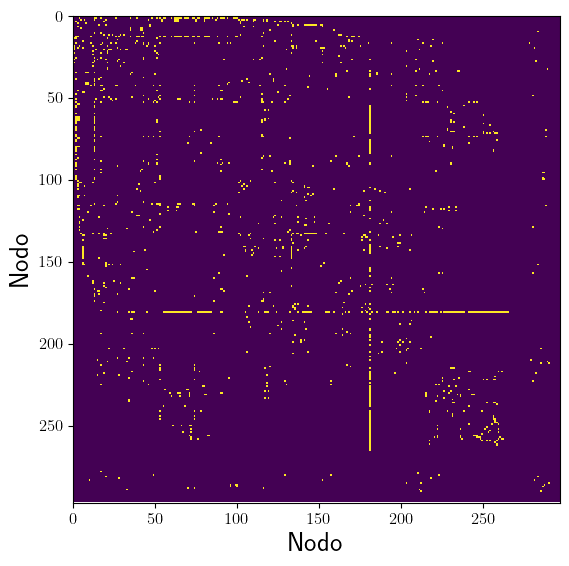

In [14]:
# =========================================================
# C. elegans
# =========================================================
# Obtener matriz de adyacencia ponderada
A_celegans_pesada = nx.to_numpy_array(celegans, weight="weight")

# Calcular percentil de corte (e.g., top 25% de los pesos)
umbral = np.percentile(A_celegans_pesada[A_celegans_pesada > 0], 75)  # solo valores > 0

# Binarizar: 1 si el peso supera el umbral, 0 si no
A_celegans_filtrada = (A_celegans_pesada >= umbral).astype(int)

# Visualizar
plt.imshow(A_celegans_filtrada, cmap='viridis', interpolation='none')
#plt.title(f"Matriz binaria (peso $>=$ {umbral:.0f}) - Top 25\% conexiones")
plt.xlabel("Nodo")
plt.ylabel("Nodo")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, A_celegans_filtrada.shape[0])
plt.ylim(A_celegans_filtrada.shape[0], 0)
plt.grid(False)
plt.tight_layout()
plt.show()

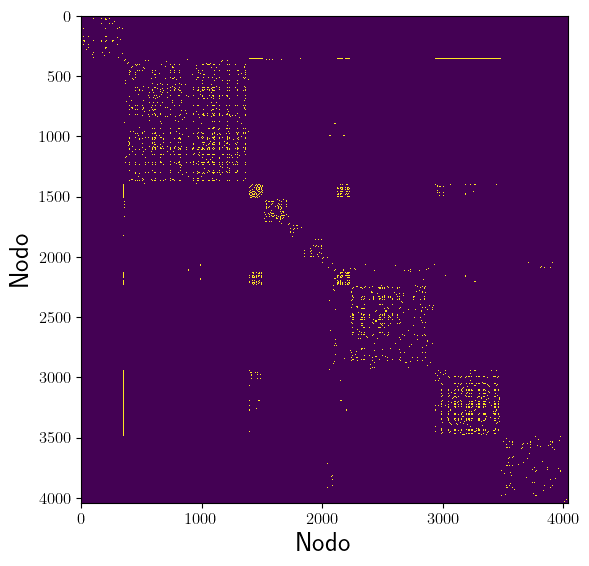

In [15]:
# ===========================================
# Facebook
# ===========================================
# Obtener matriz de adyacencia binaria
A_fb = nx.to_numpy_array(fb, weight=None)

# Visualizar
plt.imshow(A_fb, cmap='viridis', interpolation='none')
#plt.title("Matriz de adyacencia binaria - Facebook", fontsize=14)
plt.xlabel("Nodo")
plt.ylabel("Nodo")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, A_fb.shape[0])
plt.ylim(A_fb.shape[0], 0)
plt.grid(False)
plt.tight_layout()
plt.show()

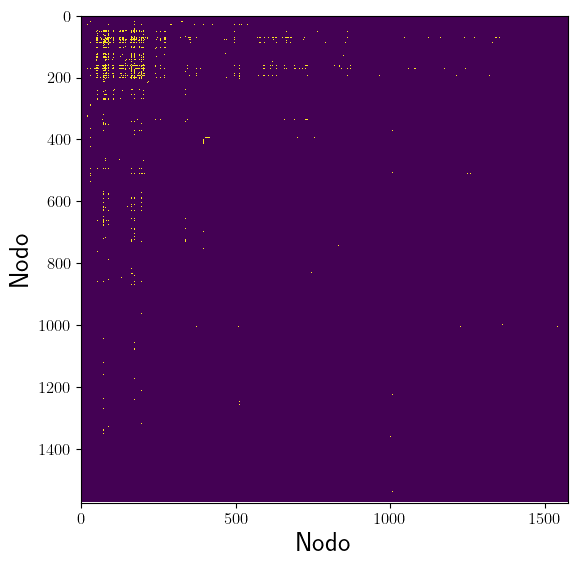

In [16]:
# ===========================================
# Airports
# ===========================================
# Convertir a grafo no dirigido (sumando los pesos donde haya doble dirección)
air_undir = air.to_undirected()

# Obtener matriz de adyacencia ponderada
A_air = nx.to_numpy_array(air_undir, weight="weight")

# Filtrar por percentil (e.g., top 25% de pesos)
umbral = np.percentile(A_air[A_air > 0], 75)

# Binarizar según umbral
A_air_bin = (A_air >= umbral).astype(int)

# Visualizar
plt.imshow(A_air_bin, cmap='viridis', interpolation='none')
#plt.title(f"Matriz binaria - Aeropuertos\n(peso ≥ {umbral:.0f}, top 25%)", fontsize=14)
plt.xlabel("Nodo")
plt.ylabel("Nodo")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0, A_air_bin.shape[0])
plt.ylim(A_air_bin.shape[0], 0)
plt.grid(False)
plt.tight_layout()
plt.show()

## Comparación con modelos prototipos

In [17]:
# =========================================================
# C. Elegans - convertir a grafo no dirigido y no ponderado
# =========================================================

# Hacer una copia primero para no alterar el original
ce_clean = celegans.copy()

# Eliminar los pesos de las aristas
drop_weights(ce_clean)

# Convertir explícitamente a no dirigido
ce_clean = nx.Graph(ce_clean)

# Número de nodos y enlaces
n = ce_clean.number_of_nodes()
m = ce_clean.number_of_edges()

# Probabilidad equivalente para el modelo de Erdős-Rényi
p_er = 2 * m / (n * (n - 1))

# Generación de prototipos
er_ce = nx.erdos_renyi_graph(n, p_er, seed=42)
ws_ce = nx.watts_strogatz_graph(n, k=round(2 * m / n), p=0.1, seed=42)
ba_ce = nx.barabasi_albert_graph(n, m=round(m / n), seed=42)
hk_ce = nx.powerlaw_cluster_graph(n, m=round(m / n), p=0.3, seed=42)  # p=0.3 = triadic closure

# Comparación con prototipos
compare_graphs(
    G_real=ce_clean,
    G_protos={"ER": er_ce, "WS": ws_ce, "BA": ba_ce, "HK": hk_ce},
    name="C. elegans"
)

--- C. elegans ---
Coef. de clustering: 0.29236329783219006
Longitud de camino promedio: 2.455318955318955
Grado medio de k: 14.464646464646465

[ER] Clustering: 0.0456 | Camino prom.: 2.4283 | k medio:14.4108
[WS] Clustering: 0.5106 | Camino prom.: 2.9904 | k medio:14.0000
[BA] Clustering: 0.1125 | Camino prom.: 2.3866 | k medio:13.6700
[HK] Clustering: 0.1910 | Camino prom.: 2.3683 | k medio:13.5623



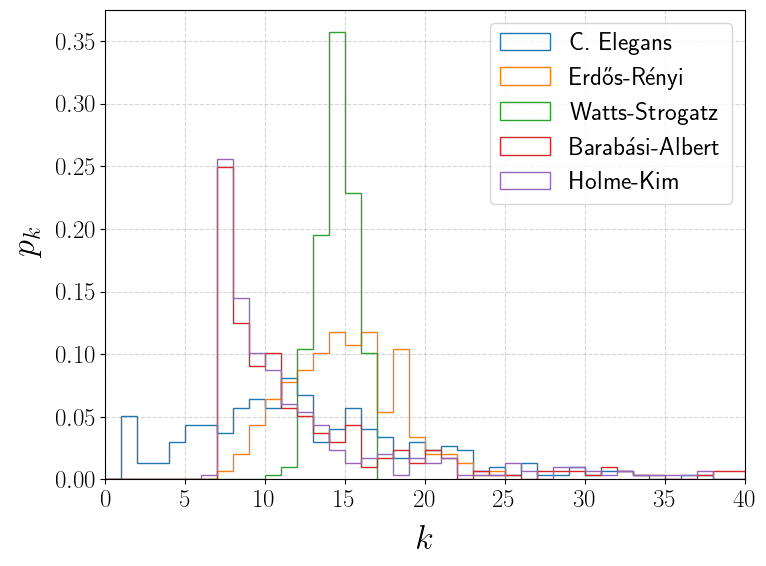

In [18]:
# Comparación de la distribución de grado
celegans_er = nx.erdos_renyi_graph(n=n, p=p_er, seed=42)
celegans_ws = nx.watts_strogatz_graph(n=n, k=round(2 * m / n), p=0.1, seed=42)
celegans_ba = nx.barabasi_albert_graph(n=n, m=round(m / n), seed=42)
celegans_hk = nx.powerlaw_cluster_graph(n=n, m=round(m / n), p=0.3, seed=42)

degrees_real_ce = [d for n, d in ce_clean.degree()]
degrees_er_ce = [d for n, d in celegans_er.degree()]
degrees_ws_ce = [d for n, d in celegans_ws.degree()]
degrees_ba_ce = [d for n, d in celegans_ba.degree()]
degrees_hk_ce = [d for n, d in celegans_hk.degree()]

# Histogramas sin relleno
plt.hist(degrees_real_ce, bins=range(max(degrees_real_ce)+1), histtype='step', label="C. Elegans", density=True)
plt.hist(degrees_er_ce, bins=range(max(degrees_er_ce)+1), histtype='step', label="Erdős-Rényi", density=True)
plt.hist(degrees_ws_ce, bins=range(max(degrees_ws_ce)+1), histtype='step', label="Watts-Strogatz", density=True)
plt.hist(degrees_ba_ce, bins=range(max(degrees_ba_ce)+1), histtype='step', label="Barabási-Albert", density=True)
plt.hist(degrees_hk_ce, bins=range(max(degrees_hk_ce)+1), histtype='step', label="Holme-Kim", density=True)

plt.xlim((0,40))
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r"$k$", fontsize=25, labelpad=10)
plt.ylabel(r"$p_k$", fontsize=25, labelpad=10)
# plt.title("Distribución de grado - C. Elegans vs Modelos Prototipos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

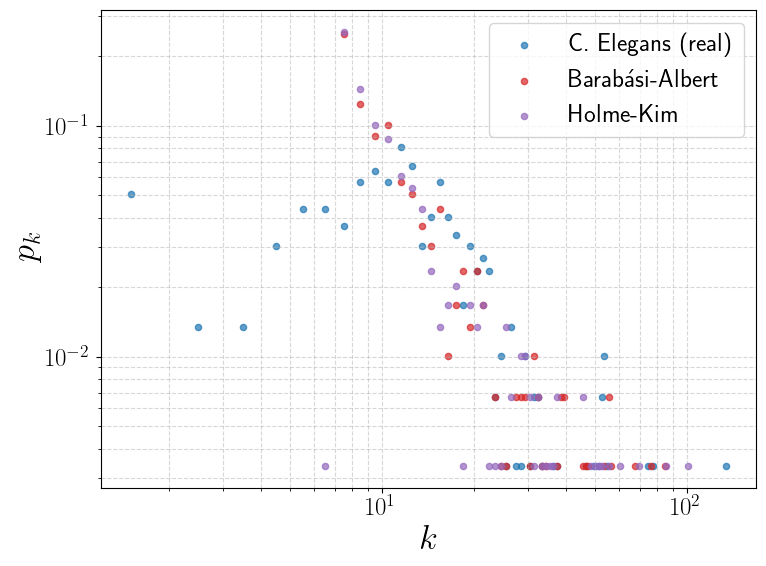

In [19]:
# Scale-free?
# Bins enteros desde 1 hasta el máximo grado observado
bins = np.arange(1, max(max(degrees_real_ce), max(degrees_er_ce), max(degrees_ws_ce), max(degrees_ba_ce), max(degrees_hk_ce)) + 2)

def plot_log_scatter(data, label, color):
    counts, edges = np.histogram(data, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    mask = (counts > 0)
    plt.scatter(centers[mask], counts[mask], label=label, alpha=0.7, s=20, color=color)

# Graficar cada modelo
plot_log_scatter(degrees_real_ce, "C. Elegans (real)", "tab:blue")
# plot_log_scatter(degrees_er_ce, "Erdős-Rényi", "tab:orange")
# plot_log_scatter(degrees_ws_ce, "Watts-Strogatz", "tab:green")
plot_log_scatter(degrees_ba_ce, "Barabási-Albert", "tab:red")
plot_log_scatter(degrees_hk_ce, "Holme-Kim", "tab:purple")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=25)
plt.ylabel(r"$p_k$", fontsize=25)
# plt.title("Distribución de grado (log-log, scatter)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# ===========================================
# Facebook - ya es no dirigido y no ponderado
# ===========================================
fb_clean = fb.copy()

n = fb_clean.number_of_nodes()
m = fb_clean.number_of_edges()
p_er = 2 * m / (n * (n - 1))

# Generación de prototipos
er_fb = nx.erdos_renyi_graph(n, p_er, seed=42)
ws_fb = nx.watts_strogatz_graph(n, k=round(2 * m / n), p=0.1, seed=42)
ba_fb = nx.barabasi_albert_graph(n, m=round(m / n), seed=42)
hk_fb = nx.powerlaw_cluster_graph(n, m=round(m / n), p=0.3, seed=42) # Donde p=0.3 es la probabilidad de triadic closure (puede ajustarse según conveniencia)

fast_compare_graphs(
    G_real=fb_clean,
    G_protos={"ER": er_fb, "WS": ws_fb, "BA": ba_fb, "HK": hk_fb},
    name="Facebook"
)

--- Facebook ---
Coef. de clustering: 0.605547
Longitud de camino promedio (estimada): 3.684000
Grado medio de k: 43.69101262688784

[ER] Clustering: 0.0108 | Camino prom. (estimado): 2.6030 | k medio:43.3538
[WS] Clustering: 0.5347 | Camino prom. (estimado): 2.9770 | k medio:44.0000
[BA] Clustering: 0.0382 | Camino prom. (estimado): 2.5280 | k medio:43.7603
[HK] Clustering: 0.0926 | Camino prom. (estimado): 2.3630 | k medio:43.5781



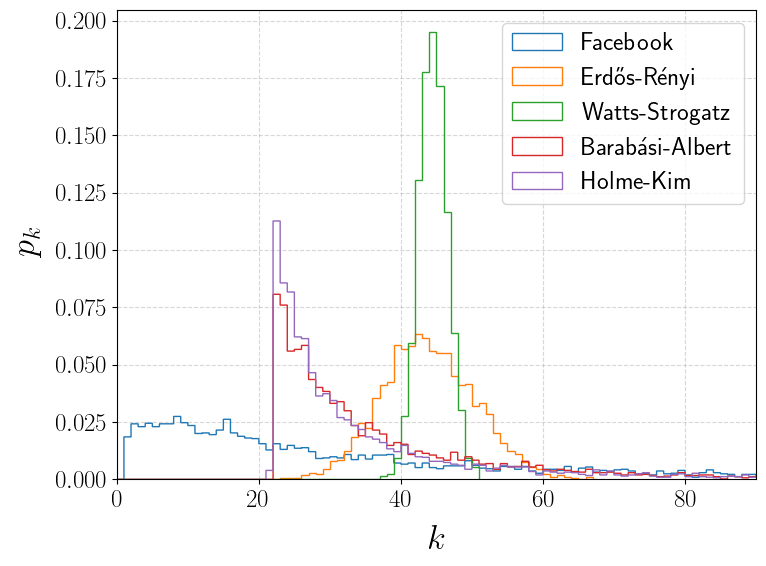

In [21]:
# Comparación de la distribución de grado
fb_er = nx.erdos_renyi_graph(n=n, p=p_er, seed=42)
fb_ws = nx.watts_strogatz_graph(n=n, k=round(2 * m / n), p=0.1, seed=42)
fb_ba = nx.barabasi_albert_graph(n=n, m=round(m / n), seed=42)
fb_hk = nx.powerlaw_cluster_graph(n=n, m=round(m / n), p=0.3, seed=42)

degrees_real_fb = [d for n, d in fb_clean.degree()]
degrees_er_fb = [d for n, d in fb_er.degree()]
degrees_ws_fb = [d for n, d in fb_ws.degree()]
degrees_ba_fb = [d for n, d in fb_ba.degree()]
degrees_hk_fb = [d for n, d in fb_hk.degree()]

# Histogramas sin relleno
plt.hist(degrees_real_fb, bins=range(max(degrees_real_fb)+1), histtype='step', label="Facebook", density=True)
plt.hist(degrees_er_fb, bins=range(max(degrees_er_fb)+1), histtype='step', label="Erdős-Rényi", density=True)
plt.hist(degrees_ws_fb, bins=range(max(degrees_ws_fb)+1), histtype='step', label="Watts-Strogatz", density=True)
plt.hist(degrees_ba_fb, bins=range(max(degrees_ba_fb)+1), histtype='step', label="Barabási-Albert", density=True)
plt.hist(degrees_hk_fb, bins=range(max(degrees_hk_fb)+1), histtype='step', label="Holme-Kim", density=True)


plt.xlim((0,90))
plt.xlabel(r"$k$", fontsize=25, labelpad=10)
plt.ylabel(r"$p_k$", fontsize=25, labelpad=10)
# plt.title("Distribución de grado - Facebook vs Modelos Prototipos")
plt.legend(loc='best')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

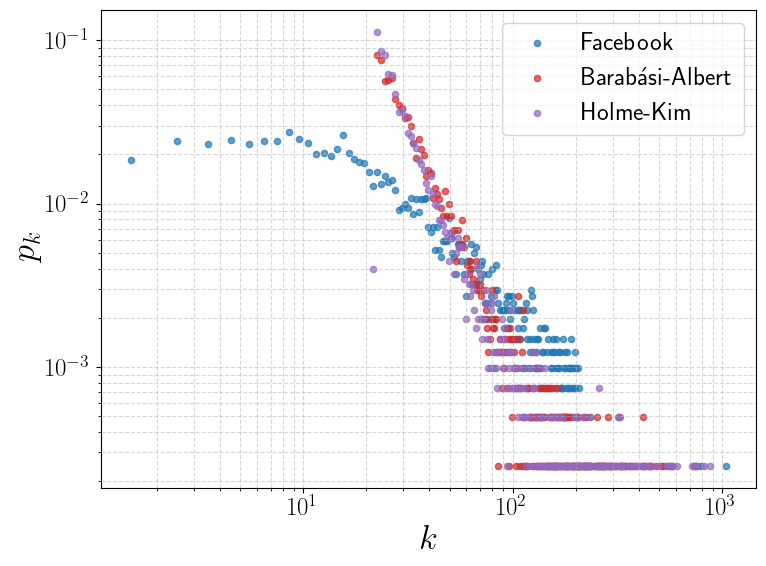

In [ ]:
# Scale-free?
# Bins enteros desde 1 hasta el máximo grado observado
bins = np.arange(1, max(max(degrees_real_fb), max(degrees_er_fb), max(degrees_ws_fb), max(degrees_ba_fb), max(degrees_hk_fb)) + 2)

def plot_log_scatter(data, label, color):
    counts, edges = np.histogram(data, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    mask = (counts > 0)
    plt.scatter(centers[mask], counts[mask], label=label, alpha=0.7, s=20, color=color)

# Graficar cada modelo
plot_log_scatter(degrees_real_fb, "Facebook", "tab:blue")
# plot_log_scatter(degrees_er_fb, "Erdős-Rényi", "tab:orange")
# plot_log_scatter(degrees_ws_fb, "Watts-Strogatz", "tab:green")La red de
plot_log_scatter(degrees_ba_fb, "Barabási-Albert", "tab:red")
plot_log_scatter(degrees_hk_fb, "Holme-Kim", "tab:purple")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=25)
plt.ylabel(r"$p_k$", fontsize=25)
# plt.title("Distribución de grado (log-log, scatter)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# ==========================================================
# Aeropuertos - convertir a grafo no dirigido y no ponderado
# ==========================================================

# Hacer una copia primero para no modificar el grafo original
air_clean = air.copy()

# Eliminar los pesos de las aristas
drop_weights(air_clean)

# Convertir explícitamente a grafo no dirigido
air_clean = nx.Graph(air_clean)

# Eliminar autoenlaces (self-loops)
air_clean.remove_edges_from(nx.selfloop_edges(air_clean))

# Extraer la componente gigante (mayor componente conexa)
giant_air = air_clean.subgraph(max(nx.connected_components(air_clean), key=len)).copy()

# Número de nodos y enlaces
n = giant_air.number_of_nodes()
m = giant_air.number_of_edges()

# Probabilidad equivalente para el modelo de Erdős-Rényi
p_er = 2 * m / (n * (n - 1))

# Generar prototipos
er_air = nx.erdos_renyi_graph(n, p_er, seed=42)
ws_air = nx.watts_strogatz_graph(n, k=round(2 * m / n), p=0.1, seed=42)
ba_air = nx.barabasi_albert_graph(n, m=round(m / n), seed=42)
hk_air = nx.powerlaw_cluster_graph(n, m=round(m / n), p=0.3, seed=42)  # p=0.3 triadic closure

# Comparar métricas
fast_compare_graphs(
    G_real=giant_air,
    G_protos={"ER": er_air, "WS": ws_air, "BA": ba_air, "HK": hk_air},
    name="Aeropuertos (componente gigante)"
)

--- Aeropuertos (componente gigante) ---
Coef. de clustering: 0.504794
Longitud de camino promedio (estimada): 3.140000
Grado medio de k: 21.900763358778626

[ER] Clustering: 0.0136 | Camino prom. (estimado): 2.7140 | k medio:21.8740
[WS] Clustering: 0.5237 | Camino prom. (estimado): 3.2820 | k medio:22.0000
[BA] Clustering: 0.0439 | Camino prom. (estimado): 2.6190 | k medio:21.8461
[HK] Clustering: 0.1092 | Camino prom. (estimado): 2.5810 | k medio:21.7519



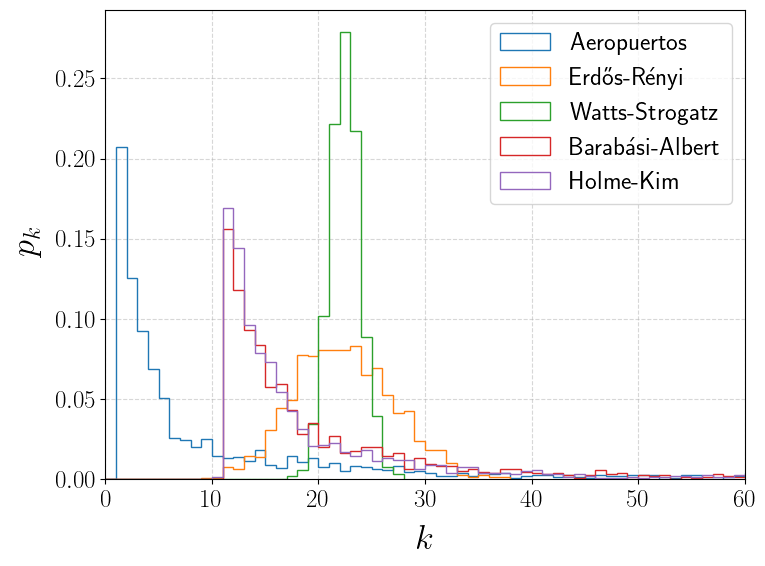

In [23]:
# Comparación de la distribución de grado
air_er = nx.erdos_renyi_graph(n=n, p=p_er, seed=42)
air_ws = nx.watts_strogatz_graph(n=n, k=round(2 * m / n), p=0.1, seed=42)
air_ba = nx.barabasi_albert_graph(n=n, m=round(m / n), seed=42)
air_hk = nx.powerlaw_cluster_graph(n=n, m=round(m / n), p=0.3, seed=42)

degrees_real_air = [d for n, d in giant_air.degree()]
degrees_er_air = [d for n, d in air_er.degree()]
degrees_ws_air = [d for n, d in air_ws.degree()]
degrees_ba_air = [d for n, d in air_ba.degree()]
degrees_hk_air = [d for n, d in air_hk.degree()]

# Histogramas sin relleno
plt.hist(degrees_real_air, bins=range(max(degrees_real_air)+1), histtype='step', label="Aeropuertos", density=True)
plt.hist(degrees_er_air, bins=range(max(degrees_er_air)+1), histtype='step', label="Erdős-Rényi", density=True)
plt.hist(degrees_ws_air, bins=range(max(degrees_ws_air)+1), histtype='step', label="Watts-Strogatz", density=True)
plt.hist(degrees_ba_air, bins=range(max(degrees_ba_air)+1), histtype='step', label="Barabási-Albert", density=True)
plt.hist(degrees_hk_air, bins=range(max(degrees_hk_air)+1), histtype='step', label="Holme-Kim", density=True)

plt.xlim((0,60))
plt.xlabel(r"$k$", fontsize=25, labelpad=10)
plt.ylabel(r"$p_k$", fontsize=25, labelpad=10)
# plt.title("Distribución de grado - Aeropuertos vs Modelos Prototipos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

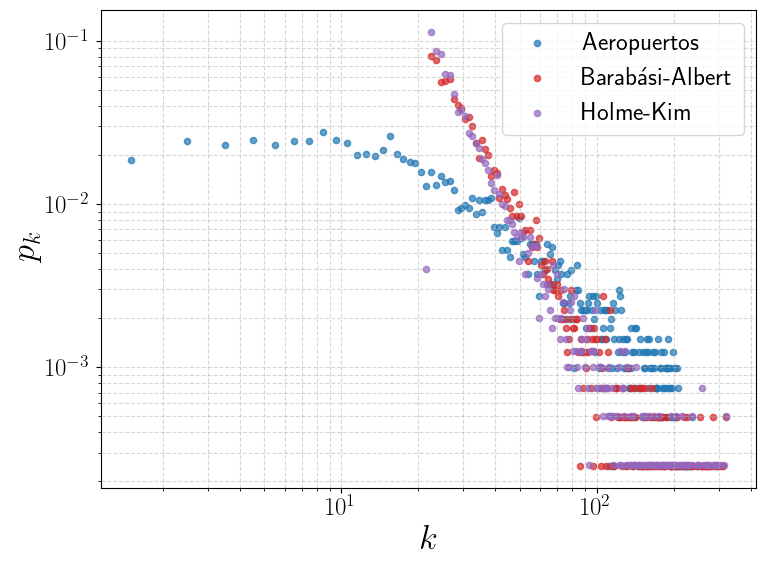

In [24]:
# Scale-free?
# Bins enteros desde 1 hasta el máximo grado observado
bins = np.arange(1, max(max(degrees_real_air), max(degrees_er_air), max(degrees_ws_air), max(degrees_ba_air), max(degrees_hk_air)) + 2)

def plot_log_scatter(data, label, color):
    counts, edges = np.histogram(data, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    mask = (counts > 0)
    plt.scatter(centers[mask], counts[mask], label=label, alpha=0.7, s=20, color=color)

# Graficar cada modelo
plot_log_scatter(degrees_real_fb, "Aeropuertos", "tab:blue")
# plot_log_scatter(degrees_er_fb, "Erdős-Rényi", "tab:orange")
# plot_log_scatter(degrees_ws_fb, "Watts-Strogatz", "tab:green")
plot_log_scatter(degrees_ba_fb, "Barabási-Albert", "tab:red")
plot_log_scatter(degrees_hk_fb, "Holme-Kim", "tab:purple")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k$", fontsize=25)
plt.ylabel(r"$p_k$", fontsize=25)
# plt.title("Distribución de grado (log-log, scatter)")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Centralidad de los nodos

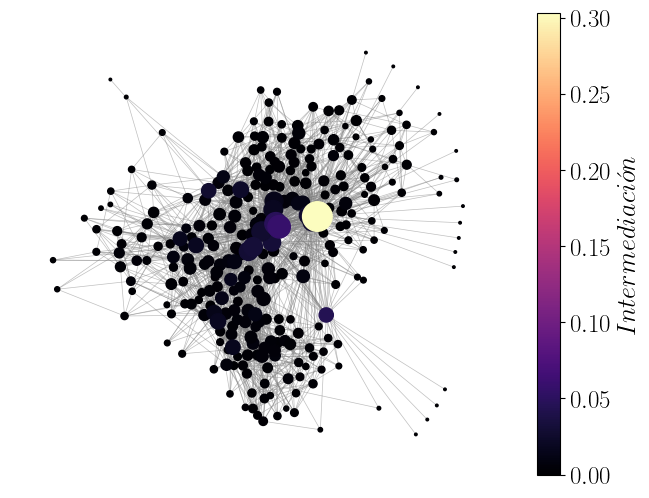

In [25]:
# ==========================================================
# C. Elegans - análisis de centralidad de nodos
# ==========================================================

# Hacer una copia del grafo para no modificar el original
ce_clean = celegans.copy()

# Eliminar los pesos de las aristas
drop_weights(ce_clean)

# Asegurar que sea no dirigido
ce_clean = nx.Graph(ce_clean)

# Calcular centralidades
deg_ce = nx.degree_centrality(ce_clean)
btw_ce = nx.betweenness_centrality(ce_clean)

# Ordenar nodos por tamaño de grado
sorted_nodes = sorted(ce_clean.nodes(), key=lambda n: deg_ce[n])

# Layout reproducible
pos = nx.spring_layout(ce_clean, seed=42)

# Visualización
# plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    ce_clean, pos,
    nodelist=sorted_nodes,  # ordenados de menor a mayor grado para mejor visualización
    node_size=[deg_ce[n] * 1000 for n in sorted_nodes],
    node_color=[btw_ce[n] for n in sorted_nodes],
    cmap=plt.cm.magma
)
nx.draw_networkx_edges(ce_clean, pos, alpha=0.5, width=0.5, edge_color='gray')
# plt.title(r"Centralidad en C. elegans (tamaño: $C_{i}^D$)")# color: $C_{bet}(i)$)")
plt.colorbar(nodes, label=r"$Intermediaci\acute{o}n$")
plt.axis("off")
plt.show()

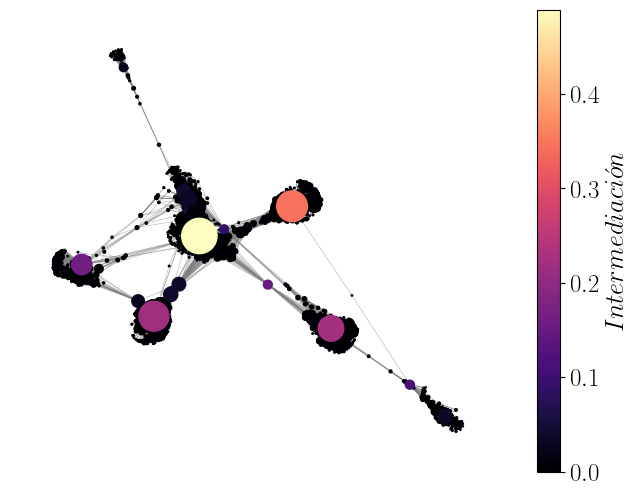

In [26]:
# ==========================================================
# Facebook - análisis de centralidad de nodos
# ==========================================================
# Ya es no dirigido
# Centralidades optimizadas
deg_fb = nx.degree_centrality(fb)
btw_fb = nx.betweenness_centrality(fb, k=500, seed=42) # Aproximado para ganar en velocidad

# Layout con menos iteraciones
#pos = nx.spring_layout(fb, seed=42, iterations=20, threshold=1e-1)

# Ordenar nodos por tamaño de grado
sorted_nodes = sorted(fb.nodes(), key=lambda n: deg_fb[n])

# Visualización ordenada
# plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    fb, pos_fb,
    nodelist=sorted_nodes,
    node_size=[deg_fb[n] * 2500 for n in sorted_nodes],
    node_color=[btw_fb[n] for n in sorted_nodes],
    cmap=plt.cm.magma
)
nx.draw_networkx_edges(fb, pos_fb, alpha=0.5, width=0.5, edge_color='gray')
# plt.title(r"Centralidad en Facebook (tamaño: $C_{i}^D$)")# color: intermediación)")
plt.colorbar(nodes, label=r"$Intermediaci\acute{o}n$")
plt.axis("off")
plt.show()

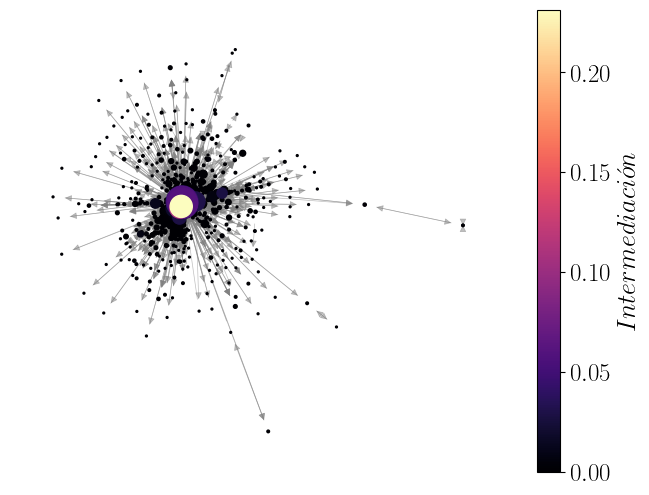

In [27]:
# ==========================================================
# Aeropuertos - análisis de centralidad de nodos
# ==========================================================
# --- Crear subgrafo con nodos que tienen posición ---
air_sub = air.subgraph(pos_air.keys()).copy()

# Ya es dirigido y ponderado
deg_in_air = nx.in_degree_centrality(air_sub)
btw_in_air = nx.betweenness_centrality(air_sub, k=500, seed=42)


# Ordenar nodos por intermediación (para que los grandes queden abajo)
sorted_nodes = sorted(air_sub.nodes(), key=lambda n: btw_in_air[n])

# Visualización
# plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    air_sub, pos_air,
    nodelist=sorted_nodes,
    node_size=[deg_in_air[n] * 2500 for n in sorted_nodes],
    node_color=[btw_in_air[n] for n in sorted_nodes],
    cmap=plt.cm.magma
)
nx.draw_networkx_edges(air_sub, pos_air, alpha=0.5, width=0.5, edge_color='gray')
# plt.title("Centralidad en Aeropuertos (tamaño: $in-C_{i}^D$)")
plt.colorbar(nodes, label=r"$Intermediaci\acute{o}n$")
plt.axis("off")
plt.show()

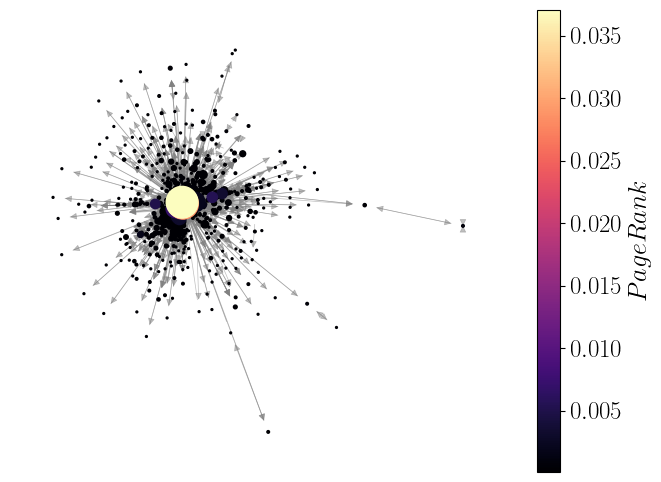

In [28]:
# ==========================================================
# Aeropuertos - análisis de centralidad de nodos
# ==========================================================
# --- Crear subgrafo con nodos que tienen posición ---
air_sub = air.subgraph(pos_air.keys()).copy()

# Ya es dirigido y ponderado
deg_in_air = nx.in_degree_centrality(air_sub)
pagerank_air = nx.pagerank(air_sub, alpha=0.85)

# Ordenar nodos por in-degree (para que los grandes queden arriba)
sorted_nodes = sorted(air_sub.nodes(), key=lambda n: deg_in_air[n])

# Visualización
# plt.figure(figsize=(10, 8))
nodes = nx.draw_networkx_nodes(
    air_sub, pos_air,
    nodelist=sorted_nodes,
    node_size=[deg_in_air[n] * 2500 for n in sorted_nodes],
    node_color=[pagerank_air[n] for n in sorted_nodes],
    cmap=plt.cm.magma
)
nx.draw_networkx_edges(air_sub, pos_air, alpha=0.5, width=0.5, edge_color='gray')
# plt.title("Centralidad en Aeropuertos (tamaño: $in-C_{i}^D$)")
plt.colorbar(nodes, label=r"$PageRank$")
plt.axis("off")
plt.show()

## Robustez estructural

In [29]:
# Función para estimar eficiencia global mediante muestreo
def estimate_efficiency(G, trials=1000):
    nodes = list(G)
    if len(nodes) < 2:
        return 0
    pairs = np.random.choice(nodes, (trials, 2))
    valid_lengths = []
    for u, v in pairs:
        try:
            d = nx.shortest_path_length(G, u, v)
            if d > 0:
                valid_lengths.append(1/d)
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            continue
    if valid_lengths:
        return sum(valid_lengths) / (len(nodes) * (len(nodes) - 1) / 2)
    else:
        return 0

In [30]:
# Robustez para grafos no dirigidos
def robustness_undirected(G, centrality_dict, method="random", perc_step=0.01, perc_limit=0.4,
                           trials_efficiency=1000, approximate=False, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    G_copy = G.copy()
    N = G_copy.number_of_nodes()
    batch_size = max(1, int(perc_step * N))

    if method == "random":
        nodes = list(G_copy.nodes())
        random.shuffle(nodes)
    elif method == "targeted":
        nodes = sorted(centrality_dict.keys(), key=lambda n: centrality_dict[n], reverse=True)
    else:
        raise ValueError("Método no reconocido: usar 'random' o 'targeted'.")

    gc_sizes = [len(max(nx.connected_components(G_copy), key=len)) / N]
    efficiencies = []

    steps = int(perc_limit / perc_step)

    for step in range(steps):
        if len(nodes) < batch_size:
            break
        selected = nodes[:batch_size]
        nodes = nodes[batch_size:]
        G_copy.remove_nodes_from(selected)

        # Componente gigante
        if G_copy.number_of_nodes() > 0:
            gc = len(max(nx.connected_components(G_copy), key=len)) / N
        else:
            gc = 0
        gc_sizes.append(gc)

        # Eficiencia
        if approximate:
            eff = estimate_efficiency(G_copy, trials=trials_efficiency)
        else:
            eff = nx.global_efficiency(G_copy)
        efficiencies.append(eff)

    return gc_sizes, efficiencies

In [31]:
# Robustez para grafos dirigidos (solo Ng/N)
def robustness_directed(G, centrality_dict, method="random", perc_step=0.01, perc_limit=0.4, seed=42):
    np.random.seed(seed)
    random.seed(seed)

    G_copy = G.copy()
    N = G_copy.number_of_nodes()
    batch_size = max(1, int(perc_step * N))

    if method == "random":
        nodes = list(G_copy.nodes())
        random.shuffle(nodes)
    elif method == "targeted":
        nodes = sorted(centrality_dict.keys(), key=lambda n: centrality_dict[n], reverse=True)
    else:
        raise ValueError("Método no reconocido: usar 'random' o 'targeted'.")

    gc_sizes = [len(max(nx.weakly_connected_components(G_copy), key=len)) / N]

    steps = int(perc_limit / perc_step)

    for step in range(steps):
        if len(nodes) < batch_size:
            break
        selected = nodes[:batch_size]
        nodes = nodes[batch_size:]
        G_copy.remove_nodes_from(selected)

        if G_copy.number_of_nodes() > 0:
            gc = len(max(nx.weakly_connected_components(G_copy), key=len)) / N
        else:
            gc = 0
        gc_sizes.append(gc)

    return gc_sizes

In [32]:
# Para C.elegans y facebook calculamos la centralidad de autovector y comparamos con PageRank
aut_ce = nx.eigenvector_centrality(ce_clean)
aut_fb = nx.eigenvector_centrality(fb)

# Y por utimo la centralidad de cecanía
clos_ce  = nx.closeness_centrality(ce_clean)
clos_fb  = nx.closeness_centrality(fb)
clos_air = nx.closeness_centrality(air_sub)

# betweenness para los aeropuertos
btw_in_air = nx.betweenness_centrality(air_sub, k=500, seed=42)

In [33]:
# Porcentaje de nodos que vamos a remover.
perc_limit = 1
perc_step = 0.05

# C. Elegans
gc_random_ce, eff_random_ce               = robustness_undirected(ce_clean, deg_ce, method="random",perc_step=perc_step,perc_limit = perc_limit, approximate=False)
gc_targeted_ce, eff_targeted_ce           = robustness_undirected(ce_clean, deg_ce, method="targeted", perc_step=perc_step,perc_limit = perc_limit, approximate=False)
gc_targeted_ce_btw, eff_targeted_ce_btw   = robustness_undirected(ce_clean, btw_ce, method="targeted", perc_step=perc_step,perc_limit = perc_limit, approximate=False)
gc_targeted_ce_aut, eff_targeted_ce_aut   = robustness_undirected(ce_clean, aut_ce, method="targeted", perc_step=perc_step,perc_limit = perc_limit, approximate=False)
gc_targeted_ce_clos, eff_targeted_ce_clos = robustness_undirected(ce_clean, clos_ce, method="targeted", perc_step=perc_step,perc_limit = perc_limit, approximate=False)

# Facebook
gc_random_fb, eff_random_fb               = robustness_undirected(fb, deg_fb, method="random",perc_step=perc_step, perc_limit = perc_limit, approximate=True)
gc_targeted_fb, eff_targeted_fb           = robustness_undirected(fb, deg_fb, method="targeted",perc_step=perc_step, perc_limit = perc_limit, approximate=True)
gc_targeted_fb_btw, eff_targeted_fb_btw   = robustness_undirected(fb, btw_fb, method="targeted",perc_step=perc_step, perc_limit = perc_limit, approximate=True)
gc_targeted_fb_aut, eff_targeted_fb_aut   = robustness_undirected(fb, aut_fb, method="targeted",perc_step=perc_step, perc_limit = perc_limit, approximate=True)
gc_targeted_fb_clos, eff_targeted_fb_clos = robustness_undirected(fb, clos_fb, method="targeted",perc_step=perc_step, perc_limit = perc_limit, approximate=True)


# Aeropuertos
gc_random_air        = robustness_directed(air_sub, deg_in_air,perc_step=perc_step,perc_limit=perc_limit, method="random")
gc_targeted_air      = robustness_directed(air_sub, deg_in_air,perc_step=perc_step,perc_limit=perc_limit, method="targeted")
gc_targeted_air_btw  = robustness_directed(air_sub, btw_in_air,perc_step=perc_step,perc_limit=perc_limit, method="targeted")
gc_targeted_air_pang = robustness_directed(air_sub, pagerank_air,perc_step=perc_step,perc_limit=perc_limit, method="targeted")
gc_targeted_air_clos = robustness_directed(air_sub, clos_air,perc_step=perc_step,perc_limit=perc_limit, method="targeted")

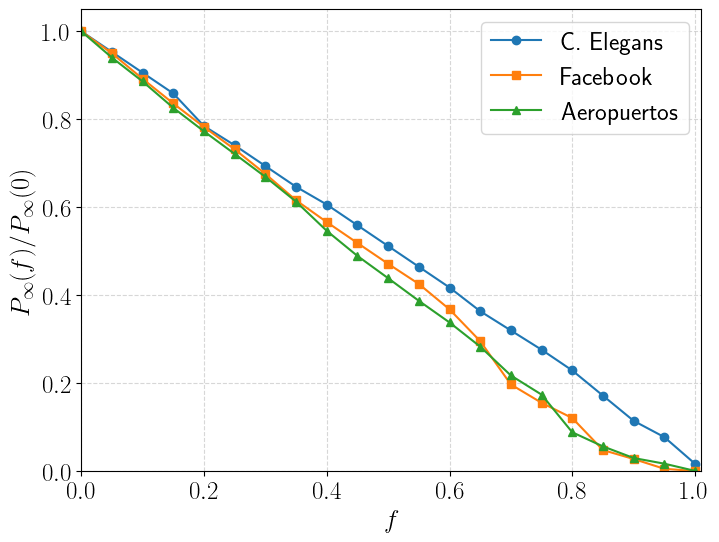

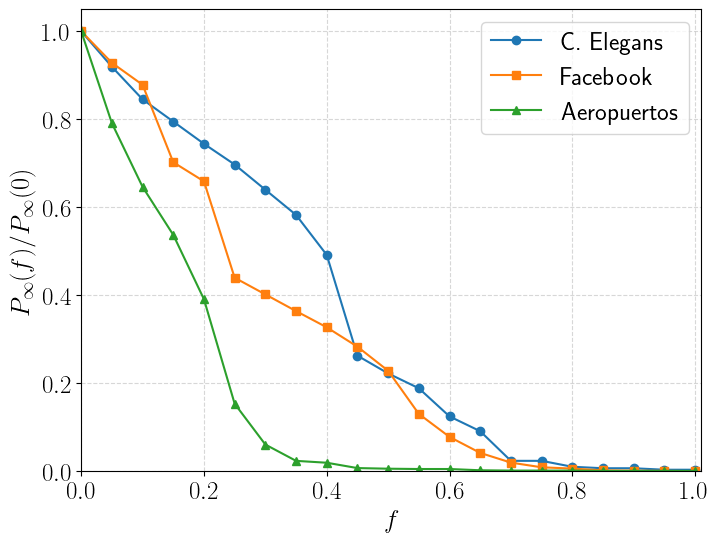

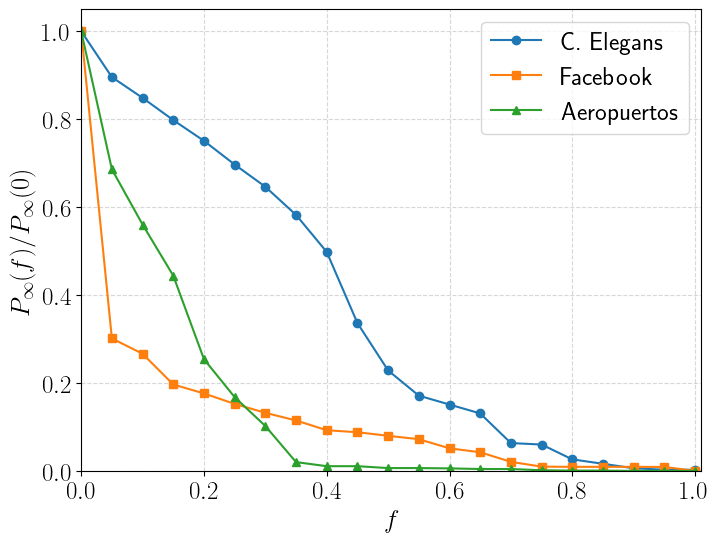

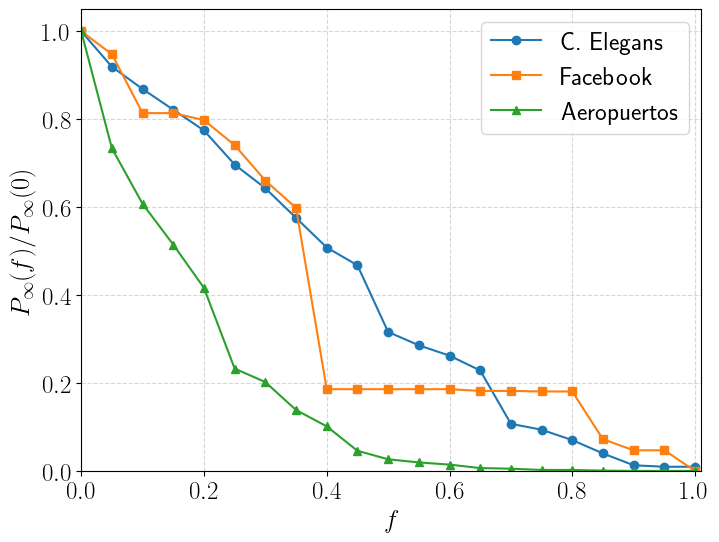

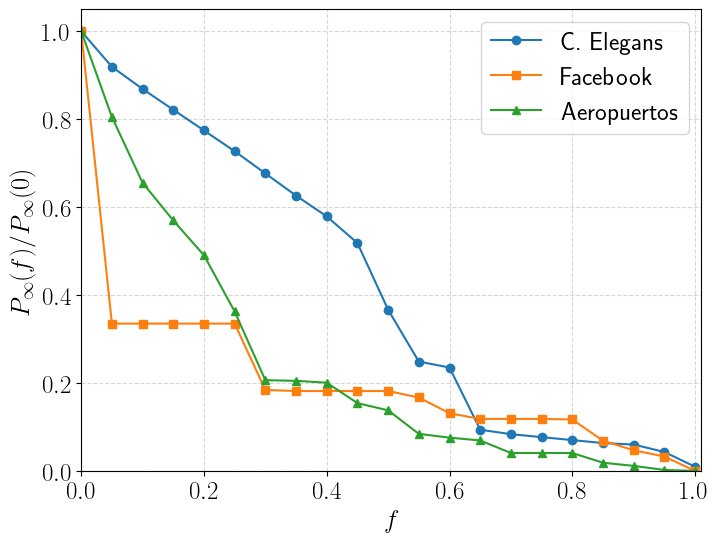

In [34]:
# ========================
# Definir ejes de x comunes
# ========================
steps = len(gc_random_ce)  # todos tienen el mismo número de pasos
x_axis = np.linspace(0, perc_limit, steps)  # porcentaje de nodos removidos (0% a perc_limit%)

# ========================
# Graficar - Random Failure
# ========================
# plt.figure(figsize=(8,6))
plt.plot(x_axis, gc_random_ce, label="C. Elegans", marker='o')
plt.plot(x_axis, gc_random_fb, label="Facebook", marker='s')
plt.plot(x_axis, gc_random_air, label="Aeropuertos", marker='^')
plt.xlabel(r"$f$")
plt.ylabel(r"$P_{\infty}(f)/P_{\infty}(0)$")
# plt.title("Robustez ante fallos aleatorios")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, perc_limit+0.01)
plt.show()

# ========================
# Graficar - Ataques dirigidos, Grado K
# ========================
# plt.figure(figsize=(8,6))
plt.plot(x_axis, gc_targeted_ce, label="C. Elegans", marker='o')
plt.plot(x_axis, gc_targeted_fb, label="Facebook", marker='s')
plt.plot(x_axis, gc_targeted_air, label="Aeropuertos", marker='^')
plt.xlabel(r"$f$")
plt.ylabel(r"$P_{\infty}(f)/P_{\infty}(0)$")
# plt.title(r"Robustez ante ataques dirigidos,$C_{i}^D$")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, perc_limit+0.01)
plt.show()

# ========================
# Graficar - Ataques dirigidos, Centralidad de intermediación (betweenness)
# ========================
plt.figure(figsize=(8,6))
plt.plot(x_axis, gc_targeted_ce_btw, label="C. Elegans", marker='o')
plt.plot(x_axis, gc_targeted_fb_btw, label="Facebook", marker='s')
plt.plot(x_axis, gc_targeted_air_btw, label="Aeropuertos", marker='^')
plt.xlabel(r"$f$")
plt.ylabel(r"$P_{\infty}(f)/P_{\infty}(0)$")
# plt.title(r"Robustez ante ataques dirigidos,$C_{bet}(i)$")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, perc_limit+0.01)
plt.show()


# ========================
# Graficar - Ataques dirigidos, Centralidad de autovector y PageRank
# ========================
# plt.figure(figsize=(8,6))
plt.plot(x_axis, gc_targeted_ce_aut, label="C. Elegans", marker='o')
plt.plot(x_axis, gc_targeted_fb_aut, label="Facebook", marker='s')
plt.plot(x_axis, gc_targeted_air_pang, label="Aeropuertos", marker='^')
plt.xlabel(r"$f$")
plt.ylabel(r"$P_{\infty}(f)/P_{\infty}(0)$")
# plt.title("Robustez ante ataques dirigidos, Autovector y PageRank")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, perc_limit+0.01)
plt.show()


# ========================
# Graficar - Ataques dirigidos, Centralidad de Cecanía
# ========================
# plt.figure(figsize=(8,6))
plt.plot(x_axis, gc_targeted_ce_clos, label="C. Elegans", marker='o')
plt.plot(x_axis, gc_targeted_fb_clos, label="Facebook", marker='s')
plt.plot(x_axis, gc_targeted_air_clos, label="Aeropuertos", marker='^')
plt.xlabel(r"$f$")
plt.ylabel(r"$P_{\infty}(f)/P_{\infty}(0)$")
# plt.title(r"Robustez ante ataques dirigidos, $C_{cer}(i)$")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.ylim(0, 1.05)
plt.xlim(0, perc_limit+0.01)
plt.show()

## Estructura comunitaria

===== Análisis de C. elegans =====
Modularidad (Louvain): 0.4907
Cantidad de Comunidades:6


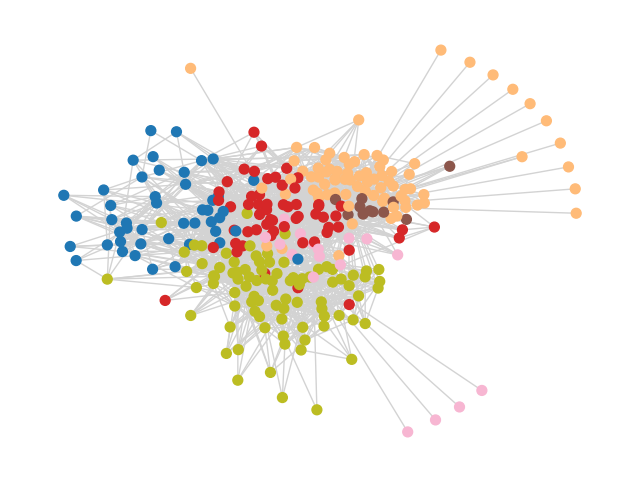

In [35]:
# ====================
# C. elegans
# ====================

print("===== Análisis de C. elegans =====")

# Louvain
partition_louvain_ce, modularity_louvain_ce , num_comunidades_ce = detect_louvain_communities(celegans)
print(f"Modularidad (Louvain): {modularity_louvain_ce:.4f}")
print(f"Cantidad de Comunidades:{num_comunidades_ce}")

pos_ce = nx.spring_layout(celegans, seed=42)
cmap = plt.get_cmap("tab20")
communities_ce = set(partition_louvain_ce.values())
colors_ce = [cmap(float(i) / len(communities_ce)) for i in range(len(communities_ce))]
color_map_ce = {community: color for community, color in zip(communities_ce, colors_ce)}
node_colors_ce = [color_map_ce[partition_louvain_ce[node]] for node in celegans.nodes()]

# plt.figure(figsize=(10, 8))
nx.draw_networkx(celegans, pos_ce, node_color=node_colors_ce, with_labels=False, node_size=50, edge_color="lightgray")
# plt.title("C. Elegans - Comunidades detectadas con Louvain")
plt.axis("off")
plt.show()

In [36]:
def fast_girvan_newman_improved(G, n_communities=5, k_samples=10, batch_remove=10, seed=42):
    """
    Versión mejorada de Girvan-Newman:
    - Remueve varias aristas con mayor betweenness aproximada
    - Guarda la mejor partición encontrada (según modularidad)
    - Se detiene cuando alcanza el número deseado de comunidades
    """
    random.seed(seed)
    G_copy = G.copy()

    best_modularity = -1
    best_partition = None

    while G_copy.number_of_edges() > 0:
        # Estimar betweenness centrality
        edge_btwn = nx.edge_betweenness_centrality(G_copy, k=k_samples, seed=random.randint(0, 10000))
        edges_sorted = sorted(edge_btwn.items(), key=lambda x: x[1], reverse=True)
        edges_to_remove = [e for e, _ in edges_sorted[:batch_remove]]
        G_copy.remove_edges_from(edges_to_remove)

        # Revisar cuántas comunidades hay ahora
        components = list(nx.connected_components(G_copy))
        num_comms = len(components)

        if num_comms >= n_communities:
            modularity = nx.community.modularity(G, components)
            if modularity > best_modularity:
                best_modularity = modularity
                best_partition = {
                    node: i for i, comm in enumerate(components) for node in comm
                }

            # Si ya tenés justo 5 comunidades y buena modularidad, podés cortar
            if num_comms == n_communities and best_modularity >= 0.5:
                break

    return best_partition, best_modularity


Buscando mejor partición: 50it [05:13,  6.26s/it]

La modularidad de la partición óptima es: 0.2817712162432745
La partición óptima tiene  9  comunidades
La partición óptima es: [[np.int64(0), np.int64(5), np.int64(8), np.int64(9), np.int64(20), np.int64(136)], [np.int64(1), np.int64(12), np.int64(19), np.int64(21), np.int64(22), np.int64(24), np.int64(25), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(152), np.int64(162), np.int64(163), np.int64(283), np.int64(284)], [np.int64(2), np.int64(3), np.int64(4), np.int64(11), np.int64(13), np.int64(14), np.int64(17), np.int64(18), np.int64(23), np.int64(26), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(42), np.int64(43), np.int64(46), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(68), np.int64(69), n

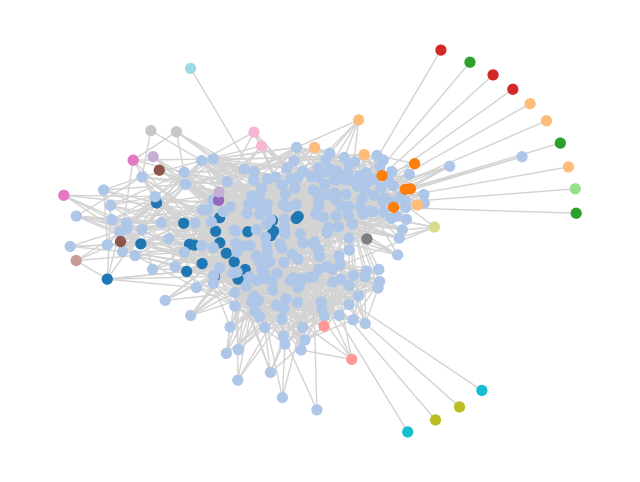

In [37]:
# Girvan-Newman
def partition_set_to_dict(m):
    d = {}
    for i,c in enumerate(m):
        for n in c:
            d[n] = i
    return d

modulos_cel = nx.community.girvan_newman(celegans)
modularidad_cel = []
mod_max_cel = -999
com_max_cel = None

# Parámetro: cuántas iteraciones sin mejora permitimos
max_iter_sin_mejora = 40
iter_sin_mejora = 0

# Límite superior para no correr infinitamente (puede ajustarse)
limite_iteraciones = 50

for communities in tqdm(itertools.islice(modulos_cel, limite_iteraciones), desc="Buscando mejor partición"):
    comunidades_ordenadas = tuple(sorted(c) for c in communities)
    n_modularidad = nx.community.modularity(celegans, comunidades_ordenadas)
    modularidad_cel.append(n_modularidad)

    if n_modularidad > mod_max_cel:
        mod_max_cel = n_modularidad
        com_max_cel = comunidades_ordenadas
        iter_sin_mejora = 0  # reiniciamos contador
    else:
        iter_sin_mejora += 1

    if iter_sin_mejora >= max_iter_sin_mejora:
        print(f"Se detuvo luego de {max_iter_sin_mejora} iteraciones sin mejora.")
        break

k=np.argmax(modularidad_cel)
comunidades_filtradas_cel = [com for com in com_max_cel if len(com) > 1]
print('La modularidad de la partición óptima es:',mod_max_cel)
print('La partición óptima tiene ',len(comunidades_filtradas_cel), ' comunidades')
print('La partición óptima es:',comunidades_filtradas_cel)

values = [v for n,v in partition_set_to_dict(com_max_cel).items()]

# Crear el diccionario con índices como claves
partition_gn_ce = {i: valor for i, valor in enumerate(values)}

communities_gn_ce = set(partition_gn_ce.values())
colors_gn_ce = [cmap(float(i) / len(communities_gn_ce)) for i in range(len(communities_gn_ce))]
color_map_gn_ce = {community: color for community, color in zip(communities_gn_ce, colors_gn_ce)}
node_colors_gn_ce = [color_map_gn_ce[partition_gn_ce[node]] for node in celegans.nodes()]

# plt.figure(figsize=(10, 8))
nx.draw_networkx(celegans, pos_ce, node_color=node_colors_gn_ce, with_labels=False, node_size=50, edge_color="lightgray")
# plt.title("C. Elegans - Comunidades detectadas con Girvan-Newman")
plt.axis("off")
plt.show()


===== Análisis de Facebook =====
Modularidad (Louvain): 0.8350
Cantidad de Comunidades:16


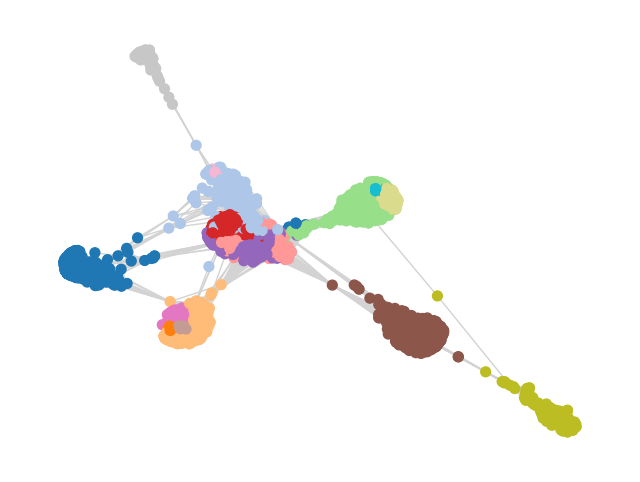

In [38]:
# ====================
# Facebook
# ====================

print("\n===== Análisis de Facebook =====")

# Louvain
partition_louvain_fb, modularity_louvain_fb, num_comunidades_fb = detect_louvain_communities(fb)
print(f"Modularidad (Louvain): {modularity_louvain_fb:.4f}")
print(f"Cantidad de Comunidades:{num_comunidades_fb}")

communities_fb = set(partition_louvain_fb.values())
colors_fb = [cmap(float(i) / len(communities_fb)) for i in range(len(communities_fb))]
color_map_fb = {community: color for community, color in zip(communities_fb, colors_fb)}
node_colors_fb = [color_map_fb[partition_louvain_fb[node]] for node in fb.nodes()]

# plt.figure(figsize=(10, 8))
nx.draw_networkx(fb, pos_fb, node_color=node_colors_fb, with_labels=False, node_size=50, edge_color="lightgray")
# plt.title("Facebook - Comunidades detectadas con Louvain")
plt.axis("off")
plt.show()

Modularidad (Girvan-Newman): 0.7078


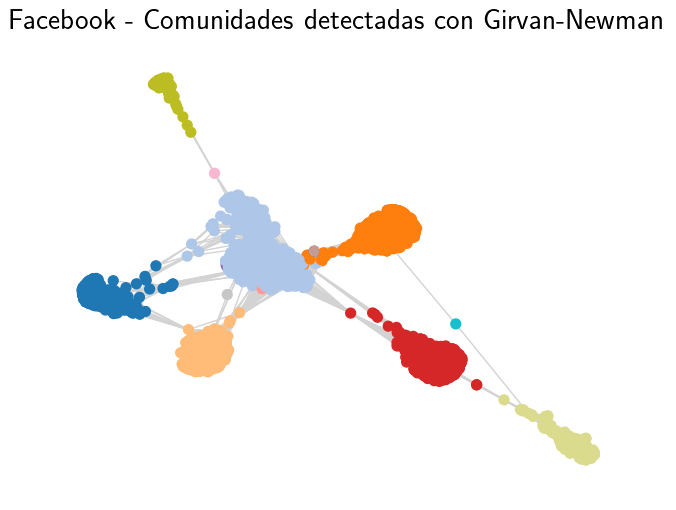

In [39]:
# Girvan-Newman
partition_gn_fb, modularity_gn_fb = fast_girvan_newman(fb, n_communities=15, k_samples=500, batch_remove=20)
print(f"Modularidad (Girvan-Newman): {modularity_gn_fb:.4f}")

communities_gn_fb = set(partition_gn_fb.values())
colors_gn_fb = [cmap(float(i) / len(communities_gn_fb)) for i in range(len(communities_gn_fb))]
color_map_gn_fb = {community: color for community, color in zip(communities_gn_fb, colors_gn_fb)}
node_colors_gn_fb = [color_map_gn_fb[partition_gn_fb[node]] for node in fb.nodes()]

# plt.figure(figsize=(10, 8))
nx.draw_networkx(fb, pos_fb, node_color=node_colors_gn_fb, with_labels=False, node_size=50, edge_color="lightgray")
plt.title("Facebook - Comunidades detectadas con Girvan-Newman")
plt.axis("off")
plt.show()


===== Análisis de Aeropuertos =====
Modularidad (Louvain): 0.2729
Cantidad de Comunidades:14


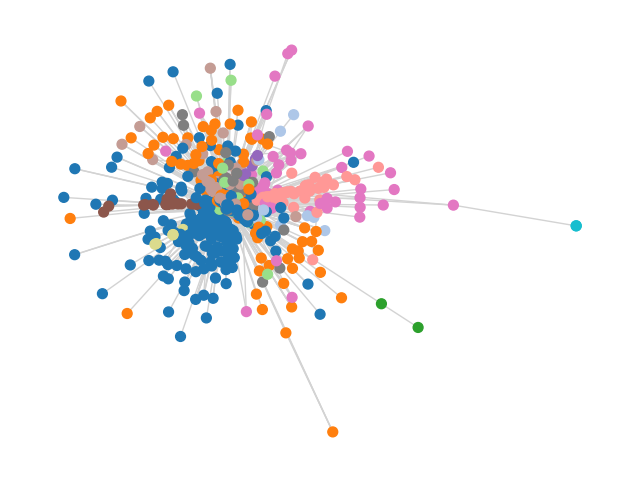

In [41]:
# ====================
# Aeropuertos
# ====================

print("\n===== Análisis de Aeropuertos =====")

# Convertir a no dirigido para Louvain
air_sub = air.subgraph(pos_air.keys()).copy()
air_undirected = air_sub.to_undirected()

# Louvain
partition_louvain_air, modularity_louvain_air, num_comunidades_air = detect_louvain_communities(air_undirected)
print(f"Modularidad (Louvain): {modularity_louvain_air:.4f}")
print(f"Cantidad de Comunidades:{num_comunidades_air}")

cmap = plt.get_cmap("tab20")
communities_air = set(partition_louvain_air.values())
colors_air = [cmap(float(i) / len(communities_air)) for i in range(len(communities_air))]
color_map_air = {community: color for community, color in zip(communities_air, colors_air)}
node_colors_air = [color_map_air[partition_louvain_air[node]] for node in air_undirected.nodes()]

# plt.figure(figsize=(10, 8))
nx.draw_networkx(air_undirected, pos_air, node_color=node_colors_air, with_labels=False, node_size=50, edge_color="lightgray")
# plt.title("Aeropuertos - Comunidades detectadas con Louvain")
plt.axis("off")
plt.show()

Modularidad (Girvan-Newman): 0.0066


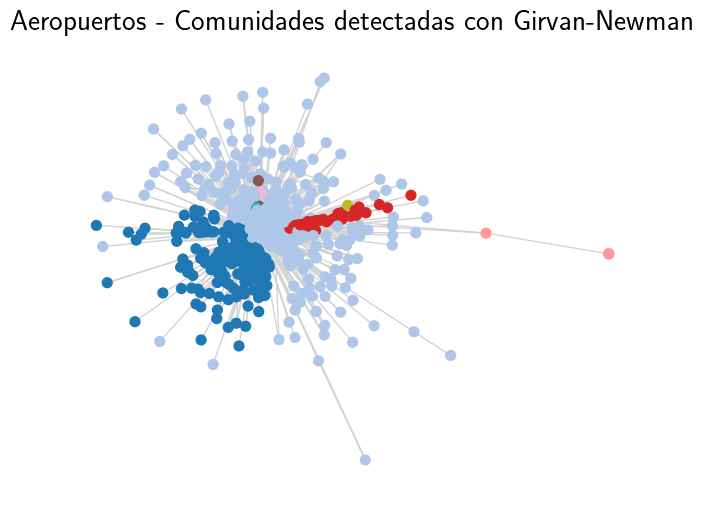

In [42]:
# Girvan-Newman
partition_gn_fast_air, modularity_gn_fast_air = fast_girvan_newman(air_undirected, n_communities=12, k_samples=1000, batch_remove=20)
print(f"Modularidad (Girvan-Newman): {modularity_gn_fast_air:.4f}")

communities_gn_fast_air = set(partition_gn_fast_air.values())
colors_gn_fast_air = [cmap(float(i) / len(communities_gn_fast_air)) for i in range(len(communities_gn_fast_air))]
color_map_gn_fast_air = {community: color for community, color in zip(communities_gn_fast_air, colors_gn_fast_air)}
node_colors_gn_fast_air = [color_map_gn_fast_air[partition_gn_fast_air[node]] for node in air_undirected.nodes()]

# plt.figure(figsize=(10, 8))
nx.draw_networkx(
    air_undirected,
    pos_air,
    node_color=node_colors_gn_fast_air,
    with_labels=False,
    node_size=50,
    edge_color="lightgray"
)
plt.title("Aeropuertos - Comunidades detectadas con Girvan-Newman")
plt.axis("off")
plt.show()